In [1]:
# Import required libraries
import numpy as np                # Mathematical functions
import pandas as pd               # data manipulation
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns
import openpyxl as pxl            # reading excel file

In [16]:
# Load the data using your own file path
data = pd.read_excel("C:\\Users\\ADMIN\\solar_battery savings\\solar-savings\\Dataset\\2020_solar_Data.xlsx", parse_dates=['date'])

# View the the dataset
print(data.dtypes, data.head())

hour                    int64
date           datetime64[ns]
solar                 float64
electricity           float64
dtype: object    hour                date  solar  electricity
0     0 2020-01-01 00:00:00    0.0     1.509849
1     1 2020-01-01 01:00:00    0.0     1.411859
2     2 2020-01-01 02:00:00    0.0     1.023898
3     3 2020-01-01 03:00:00    0.0     0.642000
4     4 2020-01-01 04:00:00    0.0     0.960000


In [17]:
# Data Cleaning
# 1. Ensure the date is in the correct datetime format
data['date'] = pd.to_datetime(data['date'])

# 2. Check for missing values
missing_vals = data.isnull().sum()
print("Missing values:", missing_vals)

Missing values: hour           0
date           0
solar          0
electricity    0
dtype: int64


There are no missing values in each column.

In [18]:
# 3. Check for duplicates
dups = data.duplicated().sum()
print("Duplicates:", dups)

Duplicates: 0


There are no duplicates in our data rows.

In [19]:
# 4. Drop rows with negative values in 'solar' and 'electricity' columns
data = data[(data['solar'] >= 0) & (data['electricity'] >= 0)]

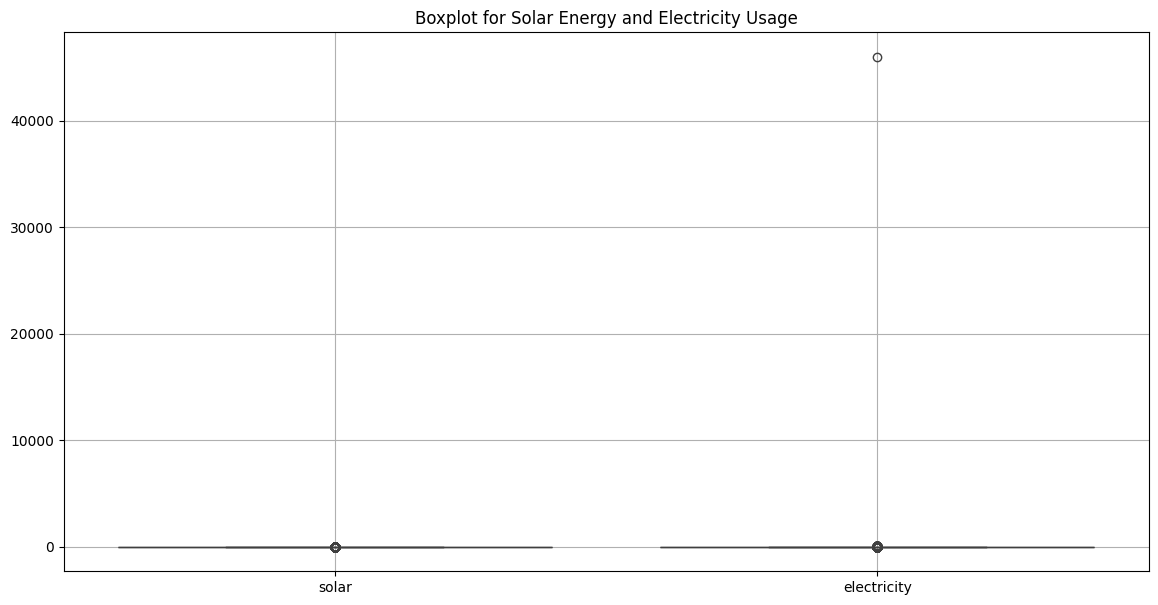

In [20]:
# 5. Investigating outliers using IQR
def detect_outliers(data, variable):
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[variable] < lower_bound) | (data[variable] > upper_bound)]
    return outliers
solar_outliers = detect_outliers(data, 'solar')
electric_outliers = detect_outliers(data, 'electricity')

# Graph representation of outliers
plt.figure(figsize=(14, 7))
sns.boxplot(data=data[['solar', 'electricity']])
plt.title('Boxplot for Solar Energy and Electricity Usage')
plt.grid(True)
plt.show()

In [21]:
# Another method to dictate outliers using dedcribe()
print(data[['solar', 'electricity']].describe())

             solar   electricity
count  8755.000000   8755.000000
mean      1.117169      7.319104
std       2.026567    491.620060
min       0.000000      0.000000
25%       0.000000      0.300000
50%       0.024000      0.621000
75%       1.275000      1.687500
max      13.050000  46000.000000


There seems to be extreme outliers in electricity usage since the maximum value (46000) is more than four times the mean and median. To correct the outliers, we can replacing the extreme values with the median or mean of the variables.

             solar  electricity
count  8755.000000  8755.000000
mean      0.853048     1.385278
std       1.550766     2.087441
min       0.000000     0.000000
25%       0.000000     0.300000
50%       0.024000     0.621000
75%       0.963000     1.497000
max       7.263000    14.572800


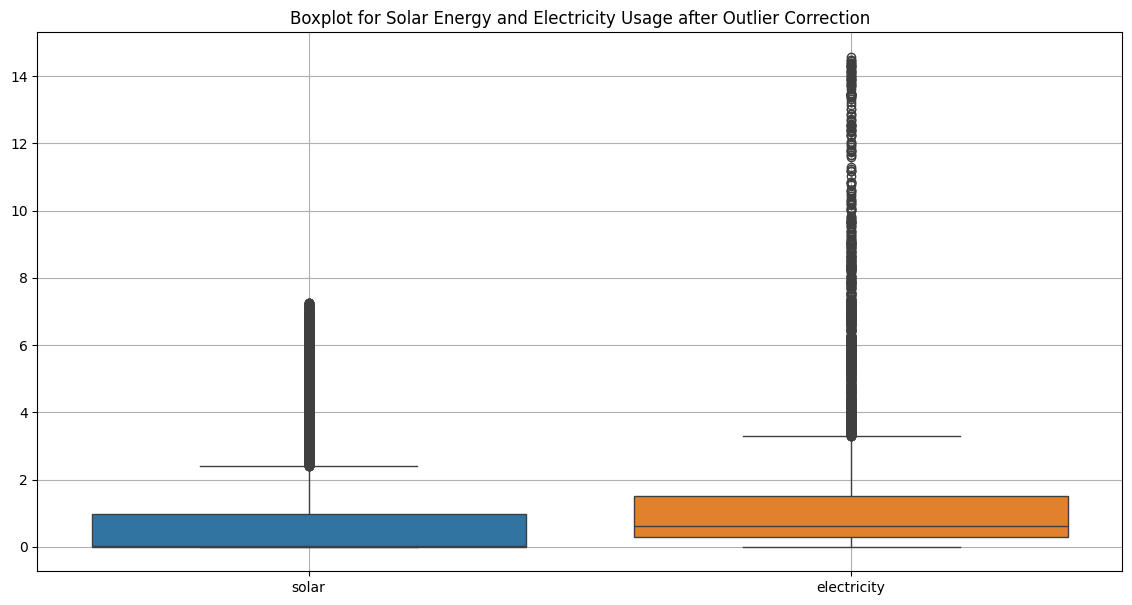

In [22]:
# Handle outliers (example: replacing with median)
data.loc[data['solar'] > solar_outliers['solar'].quantile(0.75), 'solar'] = data['solar'].median()
data.loc[data['electricity'] > electric_outliers['electricity'].quantile(0.75), 'electricity'] = data['electricity'].median()

# Verify the corrections
print(data[['solar', 'electricity']].describe())

plt.figure(figsize=(14, 7))
sns.boxplot(data=data[['solar', 'electricity']])
plt.title('Boxplot for Solar Energy and Electricity Usage after Outlier Correction')
plt.grid(True)
plt.show()

In [23]:
# Calculate avg solar energy and electricity usage each hour
hourly_avg = data.groupby('hour').agg({'solar': 'mean', 'electricity': 'mean'})
print(hourly_avg)

         solar  electricity
hour                       
0     0.000000     0.777134
1     0.000066     0.401552
2     0.000000     0.250623
3     0.000000     0.407688
4     0.078559     0.552038
5     0.270625     0.610852
6     0.722868     1.222668
7     1.394885     1.478121
8     2.085313     1.300706
9     2.242964     1.083879
10    2.133649     0.826175
11    1.983945     0.836984
12    2.125438     1.246068
13    2.153441     1.115425
14    2.272216     0.950005
15    1.609068     1.177060
16    0.790964     1.498504
17    0.365388     2.358132
18    0.160652     3.786312
19    0.047186     3.552396
20    0.012912     3.229461
21    0.008942     1.784580
22    0.010126     1.704542
23    0.000000     1.101171


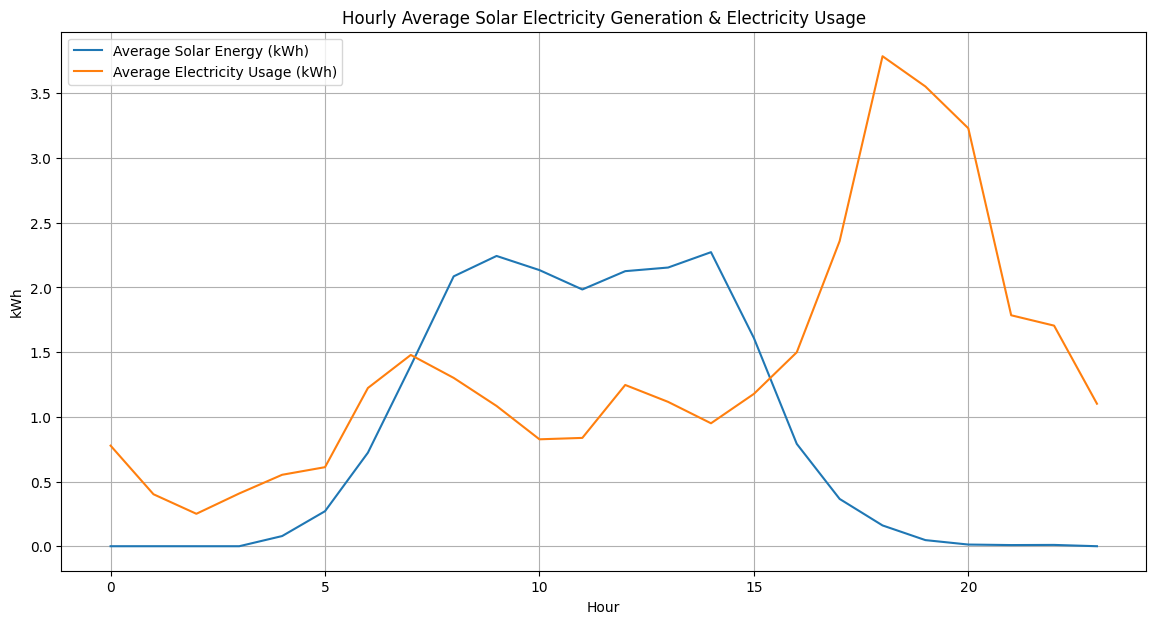

In [24]:
# Plot the averages
plt.figure(figsize=(14, 7))
sns.lineplot(data=hourly_avg, x='hour', y='solar', label='Average Solar Energy (kWh)') 
sns.lineplot(data=hourly_avg, x='hour', y='electricity', label='Average Electricity Usage (kWh)')
plt.xlabel('Hour')
plt.ylabel('kWh')
plt.title('Hourly Average Solar Electricity Generation & Electricity Usage')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Hourly electricity needed
data['electricity_needed'] = (data['electricity'] - data['solar']).clip(lower=0) #min value subjected to zero
hourly_electricity_needed = data.groupby('hour')['electricity_needed'].sum()
print('Electricity Needed per hour:\n', hourly_electricity_needed)

Electricity Needed per hour:
 hour
0      283.653806
1      146.542334
2       91.477574
3      148.806000
4      179.531000
5      174.193000
6      322.020000
7      366.399000
8      279.744000
9      200.682000
10     130.602000
11     146.340000
12     260.397000
13     218.070000
14     174.678000
15     276.465000
16     403.932000
17     748.947000
18    1324.113000
19    1279.401600
20    1174.040400
21     646.332000
22     618.462000
23     400.826349
Name: electricity_needed, dtype: float64


Hours 18-23 have high electricity needed compared to the other hours in 2020.

In [26]:
# Hourly excess solar electricity generated
data['excess_solar'] = (data['solar'] - data['electricity']).clip(lower=0)
hourly_excess_solar = data.groupby('hour')['excess_solar'].sum()
print('Excess Solar Generated per Hour:\n', hourly_excess_solar)

Excess Solar Generated per Hour:
 hour
0       0.000
1       0.000
2       0.000
3       0.000
4       6.711
5      50.010
6     139.593
7     336.018
8     565.341
9     623.748
10    607.830
11    564.981
12    581.367
13    596.946
14    657.285
15    434.148
16    145.680
17     25.581
18      0.747
19      0.000
20      0.000
21      0.000
22      0.000
23      0.000
Name: excess_solar, dtype: float64


Excess solar electricity is generated between 8-15 hours

In [27]:
## Cumulative battery charge per hour
# Assumptions: Battery already installed and charge level should:
# 1. Begin at 0 at 2020-01-01 00:00
# 2. Allow increase/decrease depending on hourly results
# 3. subject to max battery charge level
# Max battery charge level = 12.5 kWh

# Initialize the variables
max_charge = 12.5
data['battery_charge'] = 0.0

# Iteration for each hour
for i in range(len('data')):
    if i > 0:   # skip the first hour
        data.at[i, 'battery_charge'] = min(data.at[i-1, 'battery_charge'] + data.at[i-1, 'excess_solar'], max_charge)
        data.at[i, 'battery_charge'] = max(data.at[i, 'battery_charge'] + data.at[i, 'electricity_needed'], 0)

print(data[['hour', 'date', 'battery_charge']].tail())
hourly_battery_charge = data.groupby('hour')['battery_charge'].sum()
print(hourly_battery_charge)

      hour                date  battery_charge
8755    19 2020-12-31 19:00:00             0.0
8756    20 2020-12-31 20:00:00             0.0
8757    21 2020-12-31 21:00:00             0.0
8758    22 2020-12-31 22:00:00             0.0
8759    23 2020-12-31 23:00:00             0.0
hour
0     0.000000
1     1.411859
2     2.435756
3     3.077756
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
Name: battery_charge, dtype: float64


Hours 1 to 3 have high charge levels with hour 3 having the maximum charge level recorded in 2020 (3.078 kWh).

In [28]:
# Calculate net electricity consumption with battery
# Assumption: Battery already installed
data['electricity_w_bat'] = (data['electricity_needed'] - data['solar'] - data['battery_charge']).clip(lower=0)
print(data[['hour', 'date', 'electricity_w_bat']].head())
hourly_electricity_w_bat = data.groupby('hour')['electricity_w_bat'].sum()
print(hourly_electricity_w_bat)

   hour                date  electricity_w_bat
0     0 2020-01-01 00:00:00           1.509849
1     1 2020-01-01 01:00:00           0.000000
2     2 2020-01-01 02:00:00           0.000000
3     3 2020-01-01 03:00:00           0.000000
4     4 2020-01-01 04:00:00           0.960000
hour
0      283.653806
1      145.106475
2       90.453676
3      148.164000
4      172.679000
5      157.564000
6      275.367000
7      290.979000
8      224.670000
9      145.080000
10      95.646000
11     107.424000
12     196.479000
13     166.947000
14     141.756000
15     236.985000
16     343.794000
17     693.120000
18    1271.800200
19    1262.349600
20    1169.327400
21     643.077000
22     614.766000
23     400.826349
Name: electricity_w_bat, dtype: float64


Hour 17 to 23 recorded high amounts of electricity bought assuming the solar battery had already been installed.

In [30]:
# Calculation of Savings
# Initialize the variables
electricity_price = 0.17  # USD

# Electricity consumption without battery
data['electricity_wout_bat'] = data['electricity_needed']

# Savings
electricity_saved = (data['electricity_wout_bat'] - data['electricity_w_bat']).clip(lower=0)
saving_cost = electricity_saved * electricity_price
data['savings'] = saving_cost
hourly_savings = data.groupby('hour')['savings'].sum()
total_savings = data['savings'].sum()
print(data[['hour', 'date', 'savings']].head())
print("Hourly Savings for 2020:\n", round(hourly_savings,2))
print("Total Savings for 2020:", round(total_savings,2))

   hour                date   savings
0     0 2020-01-01 00:00:00  0.000000
1     1 2020-01-01 01:00:00  0.240016
2     2 2020-01-01 02:00:00  0.174063
3     3 2020-01-01 03:00:00  0.109140
4     4 2020-01-01 04:00:00  0.000000
Hourly Savings for 2020:
 hour
0      0.00
1      0.24
2      0.17
3      0.11
4      1.16
5      2.83
6      7.93
7     12.82
8      9.36
9      9.45
10     5.94
11     6.62
12    10.87
13     8.69
14     5.60
15     6.71
16    10.22
17     9.49
18     8.89
19     2.90
20     0.80
21     0.55
22     0.63
23     0.00
Name: savings, dtype: float64
Total Savings for 2020: 122.0


Hours 4 to 19 recorded significant savings with 7th hour of all days in 2020 having the maximum savings of *$12.82*. The Total savings for 2020 was *$122*.

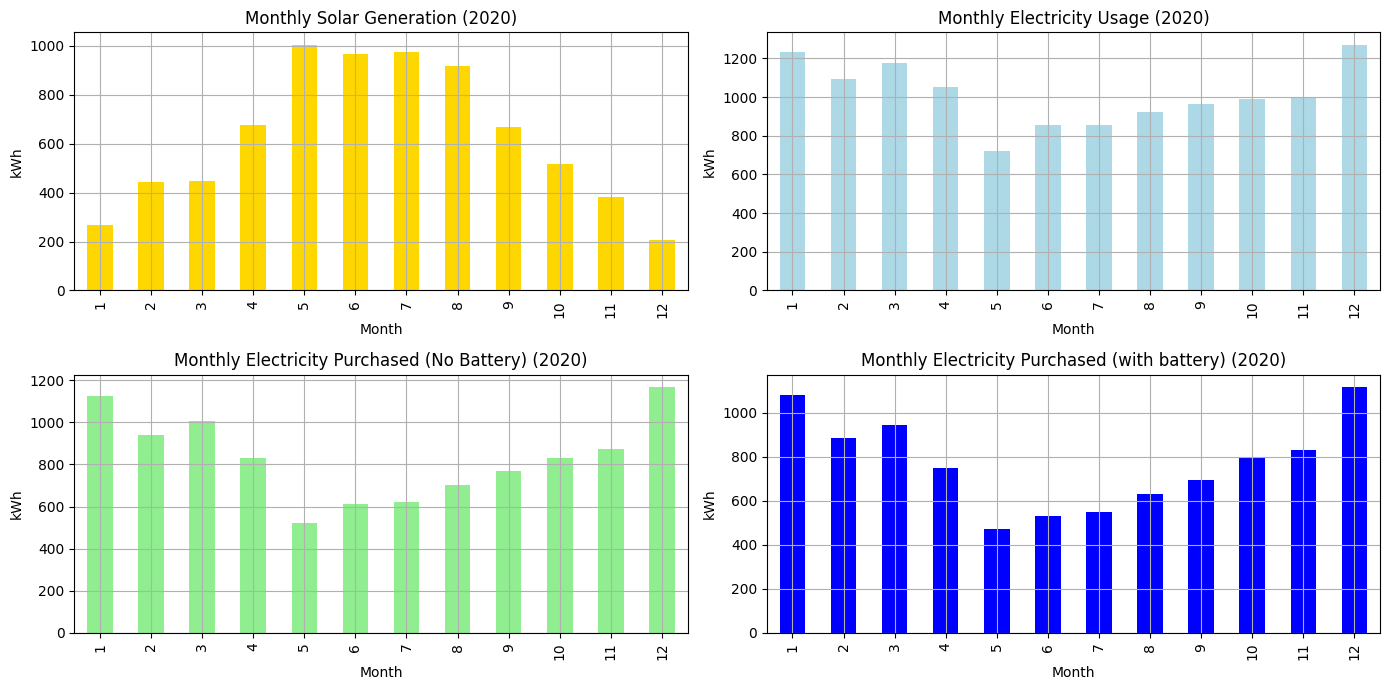

In [50]:
# Extract month from the date
data['month'] = data['date'].dt.month

# Monthly tabulation
monthly_solar = data.groupby('month')['solar'].sum()
monthly_electricity = data.groupby('month')['electricity'].sum()
monthly_electricity_wout_bat = data.groupby('month')['electricity_needed'].sum()
monthly_electricity_w_bat = data.groupby('month')['electricity_w_bat'].sum()

monthly_data = pd.DataFrame({
    'Monthly Solar Generation (kWh)': monthly_solar,
    'Monthly Electricity Usage (kWh)': monthly_electricity,
    'Monthly Electricity Purchased (No Battery)': monthly_electricity_wout_bat,
    'Monthly Electricity Purchased (with battery)': monthly_electricity_w_bat
})


#Plot the data
plt.figure(figsize=(14, 7))

# Plot Monthly Solar Generation
plt.subplot(2, 2, 1)
monthly_solar.plot(kind='bar', color='gold')
plt.title('Monthly Solar Generation (2020)')
plt.xlabel('Month')
plt.ylabel('kWh')
plt.grid(True)

# Plot Monthly Electricity Usage
plt.subplot(2, 2, 2)
monthly_electricity.plot(kind='bar', color='lightblue')
plt.title('Monthly Electricity Usage (2020)')
plt.xlabel('Month')
plt.ylabel('kWh')
plt.grid(True)

# Plot Monthly Electricity Purchased (No Battery)
plt.subplot(2, 2, 3)
monthly_electricity_wout_bat.plot(kind='bar', color='lightgreen')
plt.title('Monthly Electricity Purchased (No Battery) (2020)')
plt.xlabel('Month')
plt.ylabel('kWh')
plt.grid(True)

# Plot Monthly Electricity Purchased (with battery)
plt.subplot(2, 2, 4)
monthly_electricity_w_bat.plot(kind='bar', color='blue')
plt.title('Monthly Electricity Purchased (with battery) (2020)')
plt.xlabel('Month')
plt.ylabel('kWh')
plt.grid(True)

plt.tight_layout()
plt.show()

